In [1]:
import os
import numpy as np
import peakutils
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

%matplotlib inline

# 4$^{\circ}$ Angle

First we will plot the intensity of the "On" signal vs. the frequency at which this was rcorded. The data have been smoothed here using the Savitzky-Golay filter in order to remove unwanted noise form the signal.

In [2]:
OnFreq, On = np.loadtxt('Radio_Rot_Curve_Data_2019/4.txt',
                        skiprows=6, usecols=(0, 1), unpack=True)

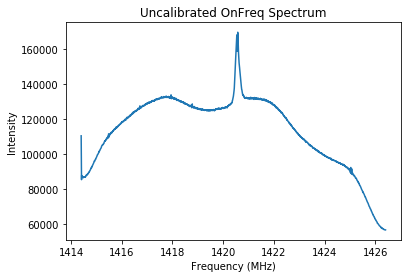

In [3]:
plt.title('Uncalibrated OnFreq Spectrum')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Intensity')

y_on = savgol_filter(On, 21, 2)

plt.plot(OnFreq, y_on)
plt.savefig('assign_2_images/4.png')

Next the intensity of the "Off" signal was plotted against the frequencies at which this was recorded, again smoothed using the `savgol` filter. The plot here shows the signal when the noise diode of the telescope was either engaged or not.

In [4]:
OffFreq, Off, Cal = np.loadtxt('Radio_Rot_Curve_Data_2019/4.txt',
                               skiprows=6, usecols=(2, 3, 4), unpack=True)

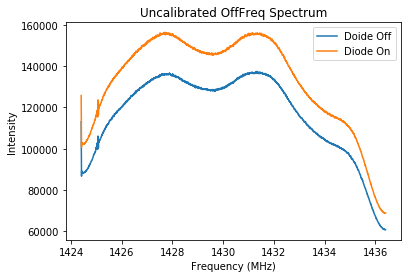

In [5]:
plt.title('Uncalibrated OffFreq Spectrum')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Intensity')

y_off = savgol_filter(Off, 21, 2)
y_cal = savgol_filter(Cal, 21, 2)

plt.plot(OffFreq, y_off, label='Doide Off')
plt.plot(OffFreq, y_cal, label='Diode On')
plt.legend()
plt.savefig('assign_2_images/4_1.png')

This plot simply combines all three so far.

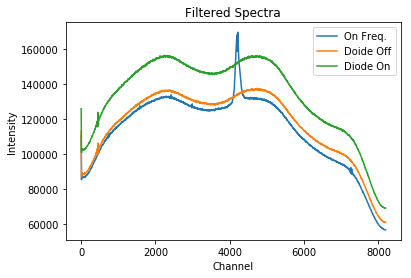

In [6]:
x = range(len(OnFreq))

plt.title('Filtered Spectra')
plt.xlabel('Channel')
plt.ylabel('Intensity')

plt.plot(x, y_on, label='On Freq.')
plt.plot(x, y_off, label='Doide Off')
plt.plot(x, y_cal, label='Diode On')
plt.legend()

plt.savefig('assign_2_images/4_2.png')

Next we will calculate the system temperature using the equation shown below. 

\begin{equation}
T_{sys} = \frac{\sum s_{offline}}{\sum(s_{calibration}-s_{offline})}T_{cal}
\end{equation}

In [7]:
T_cal = 20

s_off = np.sum(y_off)
denom = np.sum(y_cal - y_off)

T_sys = (s_off * T_cal) / denom

Now we can use `T_sys` to calculate the corrected intensity values `s`.

We can then also calculate the value of the velocity `v` correcting for the local standard of rest (LSR).

\begin{equation}
s = \frac{s_{online}}{s_{offline}}T_{sys}
\end{equation}\\

\begin{equation}
v=\frac{(1420.406-f)c}{1420.406}-v_{LSR}
\end{equation}

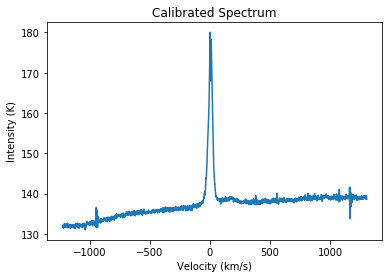

In [8]:
s = (y_on * T_sys) / y_off

c = 299792
f = OnFreq
v_num = (1420.406 - f) * c
v_LSR = -38.3829

v = (v_num / 1420.406) - v_LSR

plt.title('Calibrated Spectrum')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (K)')

plt.plot(v, s)
plt.savefig('assign_2_images/4_3.png')

This plot shows a more 'zoomed in' version of the plot above but this time with the additional presence of the uncorrected velocity curve.

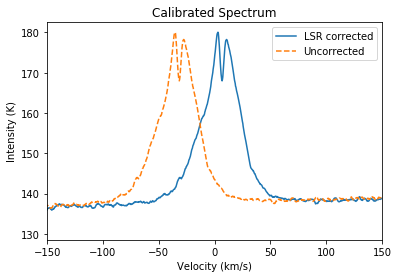

In [9]:
v_uncorrected = v + v_LSR

plt.title('Calibrated Spectrum')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (K)')

plt.plot(v, s, label='LSR corrected')
plt.plot(v_uncorrected, s, '--', label='Uncorrected')
plt.legend()

plt.xlim(-150, 150)

plt.savefig('assign_2_images/4_4.png')

Finally a value for `ΔV` can be obtained. This will be used in our final construction of the galactic rotation curve.

In [10]:
# gives the index of each detected intensity peak
indexes = peakutils.indexes(s, thres=0.5)

ΔV = []

# finds the velocity for each peak
for i in indexes:
    ΔV.append(v[i])

print('ΔV =', np.max(ΔV))

ΔV = 10.738240816997052


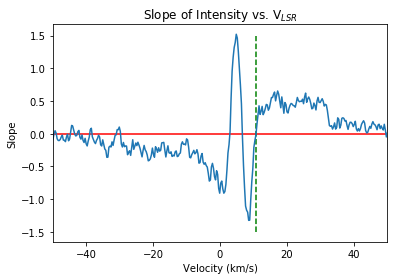

In [11]:
plt.title(r'Slope of Intensity vs. V$_{LSR}$')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Slope')

plt.plot(v, np.gradient(s))
plt.hlines(0, xmin=-50, xmax=50, color='r')
plt.xlim(-50, 50)

plt.vlines(np.max(ΔV), ymin=-1.5, ymax=1.5, color='g', linestyles='dashed')

plt.savefig('assign_2_images/4_5.png')

# Other Angles

In [12]:
file_list = []

for i in range(4, 91, 2):
    file_list.append(str(i)+'.txt')

In [13]:
data = []

for file in file_list:
    file_name = 'Radio_Rot_Curve_Data_2019/' + file
    data.append(np.loadtxt(file_name, skiprows=6))

In [14]:
LSR = np.loadtxt('Radio_Rot_Curve_Data_2019/LSR.txt', skiprows=3, usecols=1)

In [15]:
def T_sys(off, cal):
    
    T_cal = 20

    s_off = np.sum(off)
    denom = np.sum(cal - off)

    return (s_off * T_cal) / denom

In [16]:
def Delta_v(on, off, cal, on_freq, v_LSR):
    
    y_on = savgol_filter(on, 21, 2)
    y_off  = savgol_filter(off, 21, 2)
    y_cal = savgol_filter(cal, 21, 2)
    
    # calculate intensity
    s = (y_on * T_sys(y_off, y_cal)) / y_off

    c = 299792
    f = on_freq
    v_num = (1420.406 - f) * c
    
    # calculate velocity
    v = (v_num / 1420.406) - v_LSR
    
    # find peaks in intensity
    indexes = peakutils.indexes(s, thres=0.7, min_dist=40)

    ΔV = []

    # determine velocity at these peaks
    for i in indexes:
        ΔV.append(v[i])
        
    return np.max(ΔV)

Here we generate `ΔV` for each angle of longitude.

In [17]:
vel_differences = []

for i in range(len(data)):
    on = data[i][3000:6000,1]
    off = data[i][3000:6000,3]
    cal = data[i][3000:6000,4]
    on_freq = data[i][3000:6000,0]
    
    vel_differences.append(Delta_v(on, off, cal, on_freq, LSR[i]))

The equation below determines the distance from the galactic centre.

\begin{equation}
R = R_{\odot}\sin l
\end{equation}

In [18]:
l = np.arange(4, 91, 2)
l = (l * np.pi) / 180

R_solar = 8.5

R = R_solar * np.sin(l)

Finally we convert our values for `ΔV` into rotational velocities ready for plotting below.

\begin{equation}
V(R) = \Delta V + V_{0}\sin l
\end{equation}

In [19]:
v_0 = 220

V_R = np.array(vel_differences) + v_0 * np.sin(l)

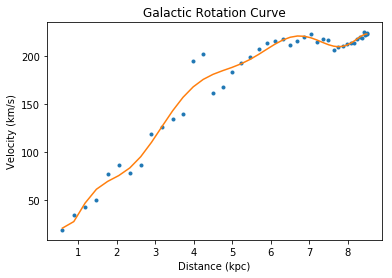

In [20]:
plt.title('Galactic Rotation Curve')
plt.xlabel('Distance (kpc)')
plt.ylabel('Velocity (km/s)')

p = np.poly1d(np.polyfit(R, V_R, 10))

plt.plot(R, V_R, '.')
plt.plot(R, p(R))
plt.savefig('assign_2_images/rotation_curve.png')

# Question 2

\begin{align}
\frac{V_c^2}{R}=\frac{GM}{R^2}\\[1em]
M=\frac{V_c^2R}{G}
\end{align}

In [27]:
v_c = np.max(V_R)
G = 4.302e-3 # pc M_⊙^-1 (km/s)^2

M = (v_c**2 * R_solar) / G

print("%.4g" % M)

1.002e+08
